# RUBIX pipeline in steps

`RUBIX` is designed as a linear pipeline, where the individual functions are called and constructed as a pipeline. This allows as to execude the whole data transformation from a cosmological hydrodynamical simulation of a galaxy to an IFU cube in two lines of code. To get a better sense, what is happening during the execution of the pipeline, this notebook splits the pipeline in small steps.

This notebook contains the functions that are called inside the rubix pipeline. To see, how the pipeline is execuded, we refer to the notebook `rubix_pipeline_single_function.ipynb`.

## Step 1: Config

The `config` contains all the information needed to run the pipeline. Those are run specfic configurations. Currently we just support Illustris as simulation, but extensions to other simulations (e.g. NIHAO) are planned.

For the `config` you can choose the following options:
- `pipeline`: you specify the name of the pipeline that is stored in the yaml file in rubix/config/pipeline_config.yml
- `logger`: RUBIX has implemented a logger to report the user, what is happening during the pipeline execution and give warnings
- `data - args - particle_type`: load only stars particle ("particle_type": ["stars"]) or only gas particle ("particle_type": ["gas"]) or both ("particle_type": ["stars","gas"])
- `data - args - simulation`: choose the Illustris simulation (e.g. "simulation": "TNG50-1")
- `data - args - snapshot`: which time step of the simulation (99 for present day)
- `data - args - save_data_path`: set the path to save the downloaded Illustris data
- `data - load_galaxy_args - id`: define, which Illustris galaxy is downloaded
- `data - load_galaxy_args - reuse`: if True, if in th esave_data_path directory a file for this galaxy id already exists, the downloading is skipped and the preexisting file is used
- `data - subset`: only a defined number of stars/gas particles is used and stored for the pipeline. This may be helpful for quick testing
- `simulation - name`: currently only IllustrisTNG is supported
- `simulation - args - path`: where the data is stored and how the file will be named
- `output_path`: where the hdf5 file is stored, which is then the input to the RUBIX pipeline
- `telescope - name`: define the telescope instrument that is observing the simulation. Some telescopes are predefined, e.g. MUSE. If your instrument does not exist predefined, you can easily define your instrument in rubix/telescope/telescopes.yaml
- `telescope - psf`: define the point spread function that is applied to the mock data
- `telescope - lsf`: define the line spread function that is applied to the mock data
- `telescope - noise`: define the noise that is applied to the mock data
- `cosmology`: specify the cosmology you want to use, standard for RUBIX is "PLANCK15"
- `galaxy - dist_z`: specify at which redshift the mock-galaxy is observed
- `galaxy - rotation`: specify the orientation of the galaxy. You can set the types edge-on or face-on or specify the angles alpha, beta and gamma as rotations around x-, y- and z-axis
- `ssp - template`: specify the simple stellar population lookup template to get the stellar spectrum for each stars particle. In RUBIX frequently "BruzualCharlot2003" is used.

In [1]:
# NBVAL_SKIP
import os
config = {
    "pipeline":{"name": "calc_ifu"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 12,
        "reuse": True,
        },

        "subset": {
            "use_subset": True,
            "subset_size": 1000,
        },
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-12.hdf5",
        },
    
    },
    "output_path": "output",

    "telescope":
        {"name": "MUSE",
         "psf": {"name": "gaussian", "size": 5, "sigma": 0.6},
         "lsf": {"sigma": 0.5},
         "noise": {"signal_to_noise": 1,"noise_distribution": "normal"},},
        
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1,
         "rotation": {"type": "edge-on"},
        },
    "ssp": {
        "template": {
            "name": "BruzualCharlot2003"
        },
    },    
}

## Step 2: RUBIX data format

First, we have to download the simulation data from the Illustris webpage and store it and transform it to the `rubixdata` format. The `rubixdata` format is a unige format for the `pipeline`. Any simulated galaxy can be transformed in the `rubixdata` format, which enables `RUBIX` to deal with all kind of cosmological hydrodynamical simulations of galaxies. For more deatails of this step, please have a look in the notebook `create_rubix_data.ipynb`.

In [2]:
# NBVAL_SKIP
from rubix.core.data import convert_to_rubix, prepare_input

convert_to_rubix(config) # Convert the config to rubix format and store in output_path folder
rubixdata = prepare_input(config) # Prepare the input for the pipeline

2024-11-14 11:25:32,285 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <
/_/|_|\____/____/___/_/|_|




2024-11-14 11:25:32,286 - rubix - INFO - Rubix version: 0.0.post101+gda5b92f.d20241101


2024-11-14 11:25:32,286 - rubix - INFO - Rubix galaxy file already exists, skipping conversion


2024-11-14 11:25:32,340 - rubix - INFO - Centering stars particles


2024-11-14 11:25:32,896 - rubix - WARNING - The Subset value is set in config. Using only subset of size 1000 for stars


You can simply access the data of the galaxy, e.g. the stellar coordinates by `rubixdata.stars.coords`.

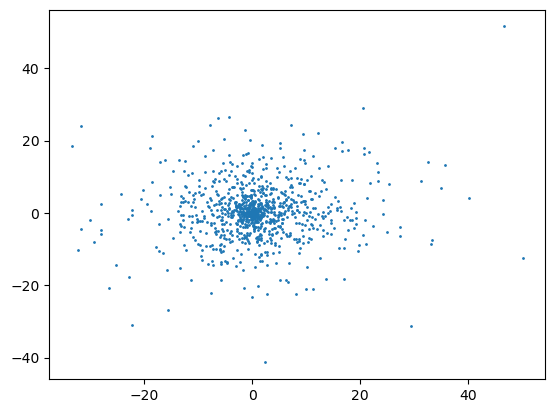

In [3]:
# NBVAL_SKIP
import matplotlib.pyplot as plt
# Make a scatter plot of the stars coordinates
plt.scatter(rubixdata.stars.coords[:,0], rubixdata.stars.coords[:,1], s=1)


## Step 3: Rotation

In the `config` we specify, how the galaxy should be orientated. In this example we want to orientate the galaxy `edge-on`. We plot the coordinates again and see that they are now rotated.

In [4]:
# NBVAL_SKIP
from rubix.core.rotation import get_galaxy_rotation
rotate = get_galaxy_rotation(config)

rubixdata = rotate(rubixdata)

2024-11-14 11:25:33,215 - rubix - DEBUG - Roataion Type found: edge-on


2024-11-14 11:25:33,216 - rubix - INFO - Rotating galaxy with alpha=90.0, beta=0.0, gamma=0.0


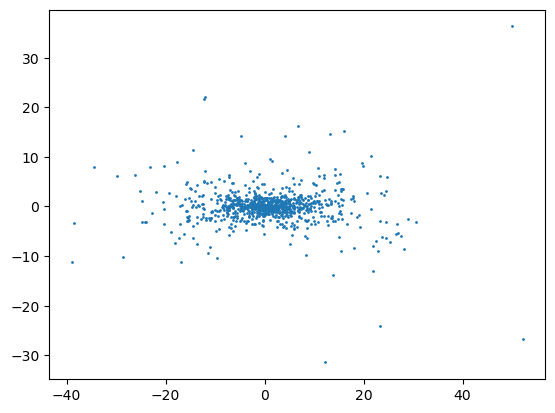

In [5]:
# Make a scatter plot of the stars coordinates after rotation
plt.scatter(rubixdata.stars.coords[:,0], rubixdata.stars.coords[:,1], s=1)

## Step 4: Filter particles

All particles outside field of view of the telescope are filtered. This has to be done, because we later bin the particles to the IFU grid and particles outside the arperture would make strange artefacts.

In [6]:
# NBVAL_SKIP
from rubix.core.telescope import get_filter_particles
filter_particles = get_filter_particles(config)

rubixdata = filter_particles(rubixdata)

2024-11-14 11:25:34,029 - rubix - INFO - Calculating spatial bin edges...


/Users/buck/Documents/Nexus/Projects/rubix/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /Users/buck/Documents/Nexus/Projects/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(


TypeCheckError: Type-check error whilst checking the parameters of rubix.telescope.base.BaseTelescope.
The problem arose whilst typechecking parameter 'signal_to_noise'.
Actual value: None
Expected type: <class 'float'>.
----------------------
Called with parameters: {
  'self':
  BaseTelescope(...),
  'fov':
  5.0,
  'spatial_res':
  0.2,
  'wave_range':
  [4700.15, 9351.4],
  'wave_res':
  1.25,
  'lsf_fwhm':
  2.51,
  'signal_to_noise':
  None,
  'sbin':
  np.int64(25),
  'aperture_region':
  f32[625],
  'pixel_type':
  'square',
  'wave_seq':
  f32[3721],
  'wave_edges':
  f32[3722]
}
Parameter annotations: (self: Any, fov: float, spatial_res: float, wave_range: List[float], wave_res: float, lsf_fwhm: float, signal_to_noise: float, sbin: int, aperture_region: Float[Array, 'sbin*sbin'], pixel_type: str, wave_seq: Float[Array, '...'], wave_edges: Float[Array, '...']) -> Any.


## Step 5: Spaxel assignment

We have an telescope aperture and a spatial resolution, which results in a spatial grid for the IFU cube. We can now assign the stars particles to the different spaxels in the IFU cube, i.e. define to which spaxel the stellar light of each stars particle contribute.

In [ ]:
# NBVAL_SKIP
from rubix.core.telescope import get_spaxel_assignment
bin_particles = get_spaxel_assignment(config)

rubixdata = bin_particles(rubixdata)

## Step 6: Reshape data

At the moment we have to reshape the rubix data that we can split the data on multiple GPUs. We plan to move from pmap to shard_map. Then this step should not be necessary any more. This step has purely computational reason and no physics motivated reason.

In [ ]:
# NBVAL_SKIP
from rubix.core.data import get_reshape_data
reshape_data = get_reshape_data(config)

rubixdata = reshape_data(rubixdata)

## Step 7: Spectra calculation

This is the heart of the `pipeline`. Now we do the lookup for the spectrum for each stellar particle. For the simple stellar population model by `BruzualCharlot2003`, each stellar particle gets a spectrum assigned based on its age and metallicity. In the plot we can see that the spectrum differs for different stellar particles.

In [ ]:
# NBVAL_SKIP
from rubix.core.ifu import get_calculate_spectra
calcultae_spectra = get_calculate_spectra(config)

rubixdata = calcultae_spectra(rubixdata)

In [ ]:
# NBVAL_SKIP
import jax.numpy as jnp

plt.plot(jnp.arange(len(rubixdata.stars.spectra[0][0][:])), rubixdata.stars.spectra[0][0][:])
plt.plot(jnp.arange(len(rubixdata.stars.spectra[0][0][:])), rubixdata.stars.spectra[0][1][:])

## Step 8: Scaling by mass

The stellar spectra have to be scaled by the stellar mass. Later heavier stellar particles should contribute more to the spectrum in a spaxel than lighter stellar particles.

In [ ]:
# NBVAL_SKIP
from rubix.core.ifu import get_scale_spectrum_by_mass
scale_spectrum_by_mass = get_scale_spectrum_by_mass(config)

rubixdata = scale_spectrum_by_mass(rubixdata)

## Step 9: Doppler shifting and resampling

The stellar particles are not at rest and therefore the emitted light is doppler shifted with respect to the observer. Before adding all stellar spectra in each spaxel, we dopplershift the spectra according to their particle velocity and we resample the spectra to the wavelength grid of the observing instrument.

In [ ]:
# NBVAL_SKIP
from rubix.core.ifu import get_doppler_shift_and_resampling
doppler_shift_and_resampling = get_doppler_shift_and_resampling(config)

rubixdata = doppler_shift_and_resampling(rubixdata)

In [ ]:
# NBVAL_SKIP
from rubix.core.pipeline import RubixPipeline 

pipe = RubixPipeline(config)

wave = pipe.telescope.wave_seq
print(wave)
print(rubixdata.stars.spectra[0][0][:])

plt.plot(wave, rubixdata.stars.spectra[0][0][:])
plt.plot(wave, rubixdata.stars.spectra[0][1][:])

## Step 10: Datacube

Now we can add all stellar spectra that contribute to one spaxel and get the IFU datacube. The plot shows the spatial dimension of the `datacube`, where we summed over the wavelength dimension.

In [ ]:
# NBVAL_SKIP
from rubix.core.ifu import get_calculate_datacube
calculate_datacube = get_calculate_datacube(config)

rubixdata = calculate_datacube(rubixdata)

In [ ]:
# NBVAL_SKIP
datacube = rubixdata.stars.datacube
img = datacube.sum(axis=2)
plt.imshow(img, origin="lower")

## Step 11: PSF

The instrument and the earth athmosphere affect the spatial resolution of the observation data and smooth in spatial dimention. To take this effect into account we convolve our datacube with a point spread function (PSF).

In [ ]:
# NBVAL_SKIP
from rubix.core.psf import get_convolve_psf
convolve_psf = get_convolve_psf(config)

rubixdata = convolve_psf(rubixdata)

In [ ]:
# NBVAL_SKIP
datacube = rubixdata.stars.datacube
img = datacube.sum(axis=2)
plt.imshow(img, origin="lower")

In [ ]:
# NBVAL_SKIP
plt.plot(wave, datacube[12,12,:])
plt.plot(wave, datacube[0,0,:])

## Step 11: LSF

The instrument affects the spectral resolution of the observation data and smooth in spectral dimention. To take this effect into account we convolve our datacube with a line spread function (LSF).

In [ ]:
# NBVAL_SKIP
from rubix.core.lsf import get_convolve_lsf
convolve_lsf = get_convolve_lsf(config)

rubixdata = convolve_lsf(rubixdata)

plt.plot(wave, rubixdata.stars.datacube[12,12,:])
plt.plot(wave, rubixdata.stars.datacube[0,0,:])

## Step 12: Noise

Observational data are never noise-free. We apply noise to our mock-datacube to mimic real measurements.

In [ ]:
# NBVAL_SKIP
from rubix.core.noise import get_apply_noise
apply_noise = get_apply_noise(config)

rubixdata = apply_noise(rubixdata)

datacube = rubixdata.stars.datacube
img = datacube.sum(axis=2)
plt.imshow(img, origin="lower")

In [ ]:
# NBVAL_SKIP
plt.plot(wave, rubixdata.stars.datacube[12,12,:])
plt.plot(wave, rubixdata.stars.datacube[0,0,:])

## DONE!

Congratulations, you have now created step by step your own mock-observed IFU datacube! Now enjoy playing around with the RUBIX pipeline and enjoy doing amazing science with RUBIX :)